In [1]:
import psycopg2, statistics, collections
from datetime import timedelta
import scipy
import pandas

%pylab inline
pylab.rcParams['figure.figsize'] = (20, 8)

Populating the interactive namespace from numpy and matplotlib


In [2]:
conn = psycopg2.connect(database="delay", user="nikita")
conn.autocommit = True

In [3]:
cur = conn.cursor()
cur.execute("SELECT * FROM heading WHERE line='95' AND way=1 ORDER BY id;")
data = cur.fetchall()

In [58]:
dates = [row[4] for row in data]
positions = [np.array(row[3]) for row in data]
positions = np.stack(positions)

subset_start = int(positions.shape[0]/2)
subset_len = 3 * 60 * 5 # we sample at 3 samples/minute and we want 4h

subset = positions[subset_start:subset_start+subset_len]
subset_dates = dates[subset_start:subset_start+subset_len]

for row, date in zip(subset, subset_dates):
    time = date.strftime("%H:%M:%S ")
    print(time + ''.join(['■' if has_bus else '□' for has_bus in row]))

04:28:22 □□□□□□□□□□□□□□□□□□□□□□□□
04:28:42 □□□□□□□□□□□□□□□□□□□□□□□□
04:29:02 □□□□□□□□□□□□□□□□□□□□□□□□
04:29:22 □□□□□□□□□□□□□□□□□□□□□□□□
04:29:42 □□□□□□□□□□□□□□□□□□□□□□□□
04:30:02 □□□□□□□□□□□□□□□□□□□□□□□□
04:30:22 □□□□□□□□□□□□□□□□□□□□□□□□
04:30:42 □□□□□□□□□□□□□□□□□□□□□□□□
04:31:02 □□□□□□□□□□□□□□□□□□□□□□□□
04:31:22 □□□□□□□□□□□□□□□□□□□□□□□□
04:31:42 □□□□□□□□□□□□□□□□□□□□□□□□
04:32:02 □□□□□□□□□□□□□□□□□□□□□□□□
04:32:22 □□□□□□□□□□□□□□□□□□□□□□□□
04:32:42 □□□□□□□□□□□□□□□□□□□□□□□□
04:33:02 □□□□□□□□□□□□□□□□□□□□□□□□
04:33:22 □□□□□□□□□□□□□□□□□□□□□□□□
04:33:42 □□□□□□□□□□□□□□□□□□□□□□□□
04:34:02 □□□□□□□□□□□□□□□□□□□□□□□□
04:34:22 □□□□□□□□□□□□□□□□□□□□□□□□
04:34:42 □□□□□□□□□□□□□□□□□□□□□□□□
04:35:02 □□□□□□□□□□□□□□□□□□□□□□□□
04:35:22 □□□□□□□□□□□□□□□□□□□□□□□□
04:35:42 □□□□□□□□□□□□□□□□□□□□□□□□
04:36:02 □□□□□□□□□□□□□□□□□□□□□□□□
04:36:22 □□□□□□□□□□□□□□□□□□□□□□□□
04:36:42 □□□□□□□□□□□□□□□□□□□□□□□□
04:37:02 □□□□□□□□□□□□□□□□□□□□□□□□
04:37:22 □□□□□□□□□□□□□□□□□□□□□□□□
04:37:42 □□□□□□□□□□□□□□□□□□□□□□□□
04:38:02 □□□□□

In [64]:
V_TRESHOLD = 15
H_TRESHOLD = 4

def assign_id(aligned, row, max_id=0):
    identified_row = np.zeros_like(row, dtype=np.int64)
    if aligned is None:
        for i, has_bus in reversed(list(enumerate(row))):
            if has_bus:
                max_id += 1
                identified_row[i] = max_id
        return identified_row, max_id
    
    for i, has_bus in reversed(list(enumerate(row))):
        if has_bus:
            for j in range(i, max(i - H_TRESHOLD, -1), -1):
                if identified_row[i]:
                    break
                for k in range(max(aligned.shape[0] - V_TRESHOLD, 0), aligned.shape[0]):
                    if row[j]:
                        # algo avancé
                        pass
                    current_cell = aligned[k][j]
                    if (current_cell != 0 
                        and current_cell not in aligned[k+1:, j+1:]
                        and  current_cell not in identified_row
                       ):
                        identified_row[i] = current_cell
                        break
                
            if identified_row[i] == 0:
                max_id += 1
                identified_row[i] = max_id

    return identified_row, max_id

In [69]:
def trajects_from_bool(data):
    aligned = None
    max_id = 0
    for row in data:
        identified_row, max_id = assign_id_better(aligned, row, max_id=max_id)
        if aligned is None:
            aligned = np.array([identified_row])
        else:
            aligned = np.vstack((aligned, identified_row))
    
    buses = collections.defaultdict(list)
    for index, x in np.ndenumerate(aligned):
        if x != 0:
            buses[x].append(index)
    
    return buses.values()

In [70]:
def skip_terminus(traject):
    index = -1
    for i, l in enumerate(traject):
        time, stop = l
        if stop == 0:
            index = i
        else:
            break
    last_terminus = index
    if last_terminus >= 0:
        return traject[last_terminus:]
    else:
        return traject

In [71]:
def reduce_traject(traject):
    seen_stops = set()
    ret = []
    for time, stop in traject:
        if stop not in seen_stops:
            ret.append([time, stop])
            seen_stops.add(stop)
    return ret

In [72]:
trajects = trajects_from_bool(subset)
trajects = map(skip_terminus, trajects)
trajects = map(reduce_traject, trajects)
trajects = list(trajects)

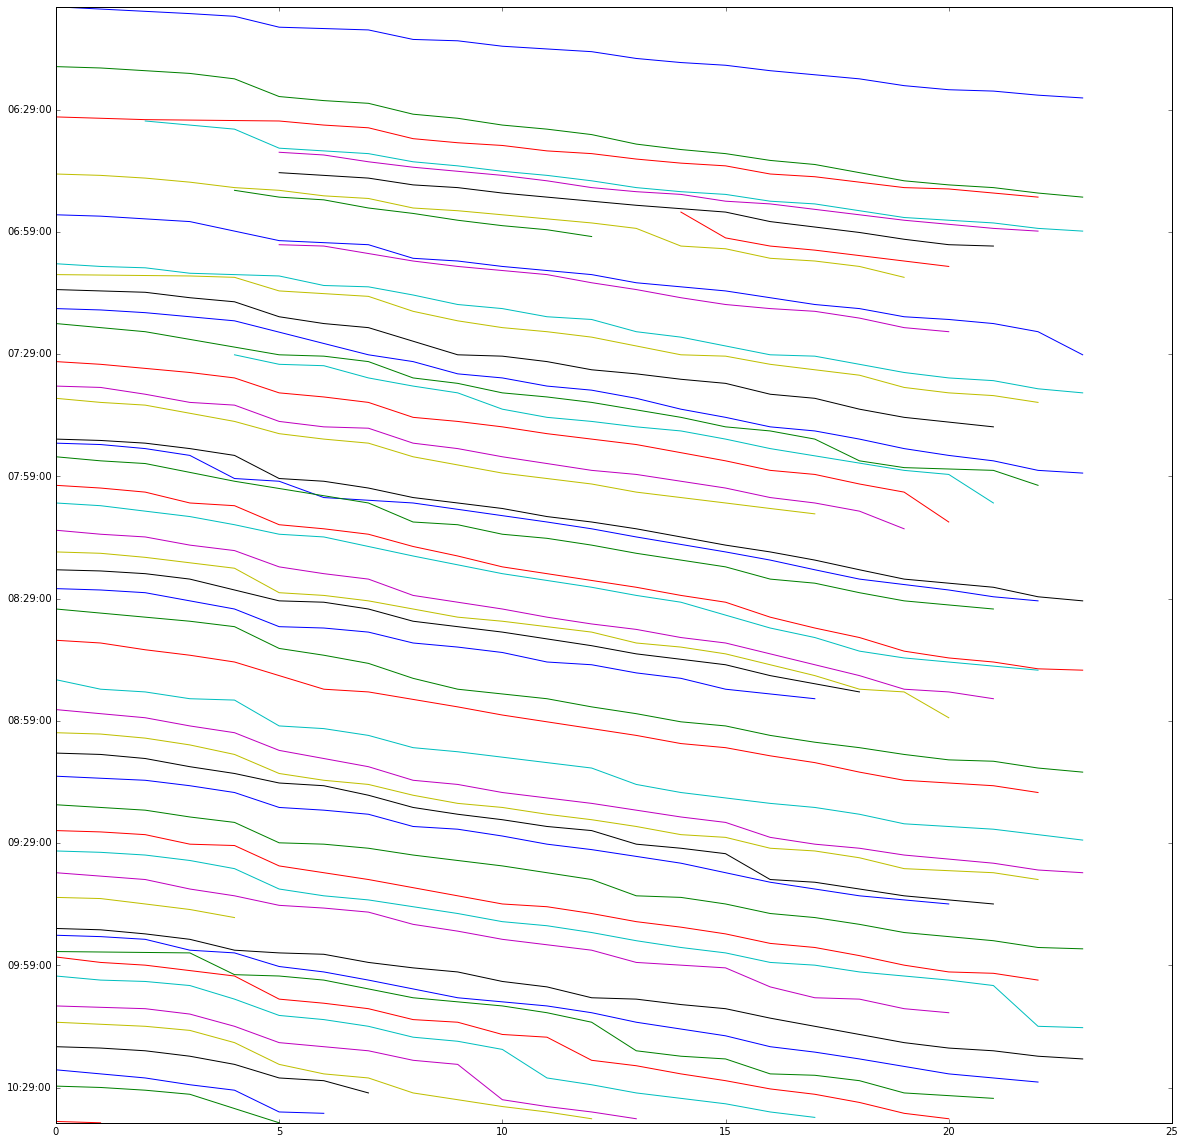

In [74]:
pylab.rcParams['figure.figsize'] = (20, 20)
plt.gca().invert_yaxis()
for traject in trajects:
    plt.plot([x[1] for x in traject], [subset_dates[x[0]] for x in traject], linewidth=1)

pylab.rcParams['figure.figsize'] = (20, 8)

15.09433962264151


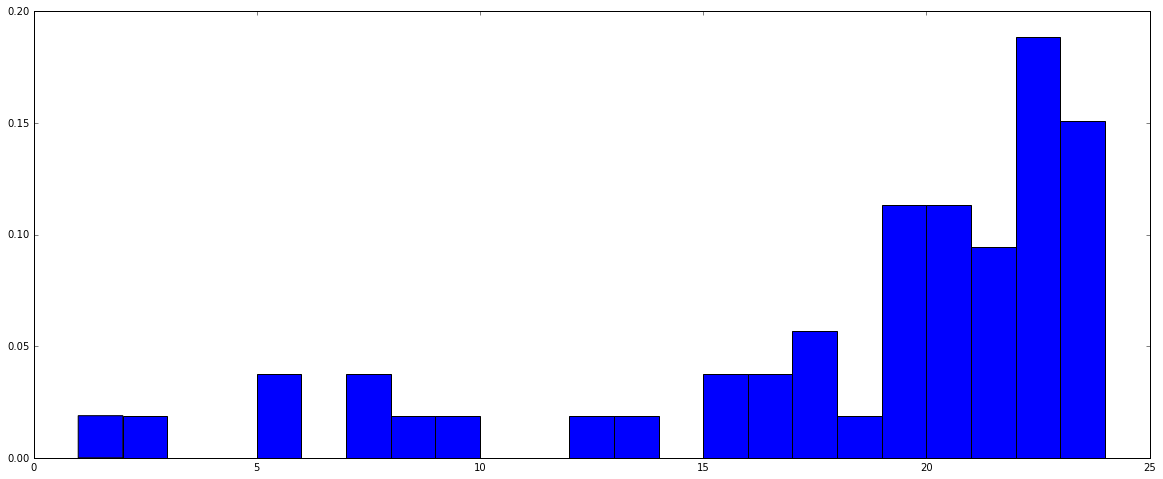

In [78]:
lengths = [len(traject) for traject in trajects]
plt.hist(lengths, bins=np.arange(min(lengths), max(lengths) + 1, 1), normed=1)

print((len(lengths) - len([x for x in lengths if x > 10]))*100/len(lengths))